In [2]:
from src.utils import *

c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
c:\Users\ubach\Projects\GQA\src\utils.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/

In [3]:
# Load required libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import fiona
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from shapely.ops import unary_union
from shapely.errors import TopologicalError
from unidecode import unidecode
import glob
import csv
from datetime import datetime
import dask.dataframe as dd
import dask_geopandas as dg
from dask.distributed import Client
import gc
import re

In [4]:
# Path to data folders
indata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas'
outdata_f = os.path.join(indata_f, 'OutputData', 'batch1_allprocessed', 'step1')
if not os.path.exists(outdata_f):
    # Create the folder if it doesn't exist
    os.makedirs(outdata_f)

# 0 PREPARE A LOG FILE FOR QC
log_file = 'log_GQA_Step1.csv'
log_path = os.path.join(outdata_f, log_file)

# Initialize Dask client
client = Client()

# Define engines
engines = {
    'fiona': {'engine': 'fiona'},
    'pyogrio': {'engine': 'pyogrio'},
    'pyogrio+arrow': {'engine': 'pyogrio', 'use_arrow': True}
          
}


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49271 instead
  warnings.warn(


In [12]:
# 1 COMMON SOURCES FOR ALL DATA
# URBAN CENTRES
# Read shapefile
uc_file_path = os.path.join(indata_f, 'UrbanCentres', 'HDC2021_RG_Input.shp')
# Read the GeoPackage file
uc = gpd.read_file(uc_file_path)
uc['CNTR_CODE'].fillna('AA', inplace=True)

# Select cities for processing in this batch
uc_sel = uc.query('Batch==1.0')
uc_sel = uc_sel.sort_values(by='CNTR_CODE')

# Read table to list the cities to process using urban centre code
cities_ls = uc_sel.HDENS_CLST.tolist()

# NOISE DATA
# Load agglomerations delineations
agls_file_path = os.path.join(indata_f, 'NoiseData', 'DF1_5_Agglomerations_20240429.gpkg')

# Read the GeoPackage file
agls = gpd.read_file(agls_file_path, layer = 'dbo.DF15_AgglomerationSource_Valid_LatestDelivery', 
                     **engines['pyogrio+arrow'],columns=['agglomerationId_identifier', 'agglomerationName_nameEng', 'geometry'])

# URBAN ATLAS
# Read table with HDENS Urban centres information and Agglomerations link
HDENS_AGGL_tbl = pd.read_csv(r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\Processing\UrbanCentres_Agglomerations_csv.csv')
# Join uc code field to this table
HDENS_AGGL_tbl = HDENS_AGGL_tbl.merge(uc[['POPL_2021', 'HDENS_CLST']], on='POPL_2021')

# TRANSLATOR TABLE
# Crosswalk table containing the different codes from input sources
codes_path = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\Processing\Codes.csv'
codes = pd.read_csv(codes_path)

In [13]:
temp_f = os.path.join(indata_f, 'Processing', 'temp')

In [20]:

len(cities_ls)

91

In [25]:
cities_ls[27]

'GEOSTAT21_363'

In [15]:
counter= 1
agl_error_ls = []


# Loop through test cities
for uc_city_code in cities_ls:
    print(counter)
    start_time = datetime.now()
    print(str(start_time))
    #urban centre boundary delineation
    uc_city = uc_sel.query(f"HDENS_CLST=='{uc_city_code}'")

    HDENS_AGGL_city = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}'")
    agl_id_city_ls = HDENS_AGGL_city.agglomerationId_identifier.values.astype(str).tolist()
    for agl_id in agl_id_city_ls:
        HDENS_AGGL_city_aglid = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}' & agglomerationId_identifier=='{agl_id}'")
        ctry_code = HDENS_AGGL_city_aglid.CNTR_CODE.values.astype(str)[0]
        aglo_name = HDENS_AGGL_city_aglid.agglomerationName_nameEng.values.astype(str)[0]
        city_agl_cd = f"{ctry_code}-{uc_city_code}-{agl_id}-{aglo_name}"
        print(city_agl_cd)
        if len(ctry_code.split('-'))>1:
               print('>1 countries')
               agl_error_ls.append(city_agl_cd + " bordering countries")
        else:
            print('1 country for this urban centre')      
            # Load agglomeration boundary for selected city
            agl_city = agls.query(f'agglomerationId_identifier == "{agl_id}"')
            if agl_city.empty:
                agglomerationId_identifier = 'NotAvailable'
                print ("agglomerationId_identifier Not Available")
                agl_error_ls.append(city_agl_cd + " agglomerationId_identifier Not Available")
            else:
                output_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
                if not os.path.exists(output_path):
                    try:
                        # Check noise contour maps GeoPackage file
                        ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export.gpkg')
                        layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'           
                        #ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export_{ctry_code}.gpkg')
                        #layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'
                        #layerName = f'dbodf48_agg_noisecontours_roadsinagglomeration_lden_valid_latestdelivery_poly_{ctry_code}'
                        ncm = gpd.read_file(ncm_file_path, layer=layerName, columns=['category', 'geometry'], 
                                            engine='pyogrio', use_arrow=True, bbox= tuple(agl_city.total_bounds))
                        print ("ncm")

                        # Define the list of noisy classes
                        noisy_classes = ['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']

                        # Create a condition based on the category column
                        condition = ncm['category'].isin(noisy_classes)  # Replace 'category_column' with the actual column name

                        # Specify the condition and create a new category column based on the condition
                        ncm['noisy'] = 0
                        ncm.loc[condition, 'noisy'] = 1
                        ncm = ncm[['noisy', 'geometry']]
                        ncm_dis_dg = dg.from_geopandas(ncm, npartitions=10)
                        ncm_dis = ncm_dis_dg.dissolve(by='noisy').compute().reset_index()
                        print ("ncm_dis")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_dis.shp')                       
                        ncm_dis.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_dis")
                    

                        # Perform spatial overlay (intersection) 
                        ncm_agl = gpd.overlay(ncm_dis, agl_city, how='intersection')
                        print ("ncm_agl")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_agl.shp')
                        ncm_agl.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_agl")

                        # Aggregate the area with lower band values (quieter bands)
                        ncm_agl_city = gpd.overlay(ncm_agl, agl_city, how='union')
                        print ("union")

                        ncm_agl_city['noisy'] = ncm_agl_city.noisy.fillna(0)
                        print ("fillna")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_agl_city.shp')                       
                        ncm_agl_city.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_agl")

                        # Select a subset of columns of interest
                        ncm_dis = ncm_agl_city[['noisy', 'geometry']]
                        print(ncm_dis)
                        

                        # 3 READ UA DATA        
                        # Load GeoPackage info
                        data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'
                        city_codes = codes.query(f'HDENS_CLST == "{uc_city_code}"')
                        ua_city_string = city_codes.UA2018.values.astype(str)[0]
                        print(ua_city_string)
                        folder_path = glob.glob(os.path.join(data_f, f'*{ua_city_string}*'))
                        ua_file_path =  glob.glob(os.path.join(folder_path[0], 'Data', f'*{ua_city_string}*.gpkg'))
                        layers_ls = fiona.listlayers(ua_file_path[0])
                        if not layers_ls:
                            agl_error_ls.append(city_agl_cd +" ua not found")
                        else:    
                            print (f"layers: {ua_file_path[0]}")

                            # Read the GeoPackage file
                            ua = gpd.read_file(ua_file_path[0], layer= layers_ls[0], 
                                            columns= ['country', 'fua_name', 'fua_code','code_2018', 'class_2018', 'geometry'], engine='pyogrio', 
                                            use_arrow=True, bbox= tuple(uc_city.total_bounds))
                            print ("loaded ua in urban city")

                            # Select 'green' classes
                            uagreen = ua.query('code_2018 == "14100" or code_2018 == "31000"')
                            
                            # 4 SELECT UA INTERSECTING UC
                            # Perform spatial overlay (intersection)
                            uagreen_urbc = gpd.overlay(uagreen, uc_city, how='intersection')
                            file_path = os.path.join(temp_f, f'{city_agl_cd}_uagreen_urbc.shp')
                            uagreen_urbc.to_file(file_path, driver='ESRI Shapefile')

                            # 5 IDENTIFY GREEN AREAS EXCLUDED (NOT COVERED BY NCM)
                            # Perform spatial overlay (intersection)                          
                            nqgreen = gpd.overlay(uagreen_urbc, ncm_dis, how='intersection') #noisy/quiet green
                            file_path = os.path.join(temp_f, f'{city_agl_cd}_nqgreen.shp')
                            nqgreen.to_file(file_path, driver='ESRI Shapefile')
                            
                            not_covered = uagreen_urbc.geometry.difference(uagreen_urbc.geometry.intersection(nqgreen.geometry.unary_union))
                            file_path = os.path.join(temp_f, f'{city_agl_cd}_not_covered.shp')
                            not_covered.to_file(file_path, driver='ESRI Shapefile')

                            # Filter out empty polygons(not empty polygons)
                            green_not_covered_by_ncm = not_covered[~not_covered.is_empty]

                            # save to shapefile
                            file_path = os.path.join(outdata_f, f'{city_agl_cd}_green_not_covered_by_ncm.shp')
                            green_not_covered_by_ncm.to_file(file_path, driver='ESRI Shapefile')
                            print ("green_not_covered_by_ncm")

                            # 6 IDENTIFY QUIET/NOISY AREAS
                            ## for statistics need to calculate area again
                            # Calculate the area for each geometry and create a new column 'area'
                            nqgreen['area_m2'] = nqgreen['geometry'].area
                            nqgreen['area_ha'] = round(nqgreen['area_m2']* 0.0001,2)
                            nqgreen['area_km2'] = round(nqgreen['area_ha']* 0.01,2)
                            nqgreen_area = nqgreen.groupby(['code_2018', 'noisy'])['area_m2'].sum().reset_index()
                            nqgreen_area['area_ha'] = round(nqgreen_area['area_m2']* 0.0001,2)
                            nqgreen_area['area_km2'] = round(nqgreen_area['area_ha']* 0.01,2)

                            # 7 EXPORT GREEN QUIET AREAS (GQA)
                            nqgreen = nqgreen[['country', 'fua_name', 'fua_code', 'HDENS_2011', 'code_2018', 'class_2018', 'noisy',  'area_m2', 'area_ha', 'area_km2', 'geometry']]
                            GQA = nqgreen.query('noisy == 0')
                            GNA = nqgreen.query('noisy == 1')

                            # Export to shapefile
                            file_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA.shp')
                            GQA.to_file(file_path, driver='ESRI Shapefile')
                            print ("GQA")

                            # 8 CREATE CENTROIDS FOR GQA POLYGONS
                            # Create a new GeoDataFrame with centroids as points
                            GQA_pts = gpd.GeoDataFrame(geometry=GQA['geometry'].centroid)
                            GQA_pts['oid'] = GQA.index
                            GQA_pts['fua_name'] = GQA.fua_name
                            GQA_pts['fua_code'] = GQA.fua_code
                            GQA_pts['HDENS_2011'] = GQA.HDENS_2011

                            # Export to shapefile
                            file_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
                            GQA_pts.to_file(file_path, driver='ESRI Shapefile')
                            print ("GQA_pts")
                    
                            # Calculate the duration
                            end_time = datetime.now()
                            processing_time = end_time - start_time

                            print ("str(processing_time)")
                            
                            ## write output values into log file
                            uc_km2 = round(uc_city.area.sum()/1000000,2)
                            agl_city_km2 = round(agl_city.area.sum()/1000000,2)
                            ncm_agl_city_km2 = round(ncm_agl_city.area.sum()/1000000,2)
                            ua_km2 = round(ua.area.sum()/1000000,2)
                            uagreen_km2 = round(uagreen.area.sum()/1000000,2)
                            uagreen_urbc_km2 = round(uagreen_urbc.area.sum()/1000000,2)
                            nqgreen_m2 = round(nqgreen.area.sum(),2)
                            green_not_covered_by_ncm_m2 = round(green_not_covered_by_ncm.area.sum(),2)
                            GQA_m2 = round(GQA.area.sum(),2)
                            GNA_m2 = round(GNA.area.sum(),2)
                            processing_duration = str(processing_time)

                            log_entry = create_log_entry(aglo_name, agl_id, uc_km2, agl_city_km2, 
                                                    ncm_agl_city_km2,ua_km2, uagreen_km2, uagreen_urbc_km2, nqgreen_m2, 
                                                    green_not_covered_by_ncm_m2, GQA_m2, GNA_m2, processing_time)
                            write_log(log_path, log_entry)

                            # Clean up intermediate variables to free memory
                            del agl_city, ncm, ncm_agl, ncm_agl_city, ncm_dis, ua, uagreen, uagreen_urbc, nqgreen, green_not_covered_by_ncm, GQA, GNA, GQA_pts
                    except:
                        print("Error " + city_agl_cd)
                        agl_error_ls.append(city_agl_cd +" Error")
        counter= counter+1

print(agl_error_ls)

1
2024-07-25 15:33:17.355767
AT-GEOSTAT21_520-AG_AT_00_5-Innsbruck
1 country for this urban centre
2
2024-07-25 15:33:17.425758
AT-GEOSTAT21_522-AG_AT_00_2-Graz
1 country for this urban centre
3
2024-07-25 15:33:17.443758
AT-GEOSTAT21_495-AG_AT_00_4-Salzburg
1 country for this urban centre
4
2024-07-25 15:33:17.455757
AT-GEOSTAT21_479-AG_AT_00_3-Linz
1 country for this urban centre
5
2024-07-25 15:33:17.469758
AT-GEOSTAT21_481-AG_AT_00_1-Wien
1 country for this urban centre
6
2024-07-25 15:33:17.485757
BE-GEOSTAT21_317-AG_BE_FL_1-Antwerp
1 country for this urban centre
7
2024-07-25 15:33:17.497757
BE-GEOSTAT21_300-AG_BE_FL_1-Antwerp
1 country for this urban centre
8
2024-07-25 15:33:17.509757
BE-GEOSTAT21_332-AG_BE_FL_2-Ghent
1 country for this urban centre
9
2024-07-25 15:33:17.520758
BE-GEOSTAT21_344-AG_BE_FL_4-Leuven
1 country for this urban centre
10
2024-07-25 15:33:17.540770
BE-GEOSTAT21_364-AG_BE_WA_2-Liege
1 country for this urban centre
11
2024-07-25 15:33:17.555771
BE-GEOSTAT

Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_215612\149241173.py:72: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ncm_agl.to_file(file_path, driver='ESRI Shapefile')


exported ncm_agl
union
fillna


Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_215612\149241173.py:84: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ncm_agl_city.to_file(file_path, driver='ESRI Shapefile')


exported ncm_agl
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((6470226.595 1659261.113, 64702...
1    0.0  MULTIPOLYGON (((6467124.765 1649082.798, 64671...
not available
Error CY-GEOSTAT21_845-AG_CY_00_4-Larnaca
19
2024-07-25 15:34:26.296937
CY-GEOSTAT21_856-AG_CY_00_5-Limassol
1 country for this urban centre
20
2024-07-25 15:34:26.307962
CZ-GEOSTAT21_358-AG_CZ_00_006-Liberec
1 country for this urban centre
21
2024-07-25 15:34:26.335933
CZ-GEOSTAT21_414-AG_CZ_00_007-Olomouc
1 country for this urban centre
22
2024-07-25 15:34:26.352960
CZ-GEOSTAT21_416-AG_CZ_00_005-Pilsen
1 country for this urban centre
23
2024-07-25 15:34:26.367943
CZ-GEOSTAT21_430-AG_CZ_00_002-Brno
1 country for this urban centre
24
2024-07-25 15:34:26.385940
CZ-GEOSTAT21_362-AG_CZ_00_004-Usti nad Labem - Teplice
1 country for this urban centre
25
2024-07-25 15:34:26.396939
CZ-GEOSTAT21_402-AG_CZ_00_001-Prague
1 country for this urban centre
26
2024-07-25 15:34:26.406944
CZ-GEO

Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_215612\149241173.py:72: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ncm_agl.to_file(file_path, driver='ESRI Shapefile')


exported ncm_agl


Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_215612\149241173.py:76: UserWarning: `keep_geom_type=True` in overlay resulted in 15434 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ncm_agl_city = gpd.overlay(ncm_agl, agl_city, how='union')
Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_215612\149241173.py:84: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ncm_agl_city.to_file(file_path, driver='ESRI Shapefile')


union
fillna
exported ncm_agl
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((4098949.826 3094340.178, 40989...
1    1.0  MULTIPOLYGON (((4119661.376 3096547.011, 41196...
2    0.0  MULTIPOLYGON (((4097919.094 3095681.980, 40979...
DE004L1_KOLN_UA2018_v013
layers: A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018\DE004L1_KOLN_UA2018_v013\Data\DE004L1_KOLN_UA2018_v013.gpkg
loaded ua in urban city


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Error DE-GEOSTAT21_363-AG_DE_NW_1-Cologne
30
2024-07-25 15:51:55.349882
DE-GEOSTAT21_145-AG_DE_HB_1-Bremen
1 country for this urban centre
31
2024-07-25 15:51:55.363887
DE-GEOSTAT21_413-AG_DE_HE_4-Darmstadt
1 country for this urban centre
32
2024-07-25 15:51:55.374881
DE-GEOSTAT21_186-AG_DE_BE_1-Berlin
1 country for this urban centre
33
2024-07-25 15:51:55.392882
DE-GEOSTAT21_346-AG_DE_NW_24-Bergisch Gladbach
1 country for this urban centre
DE-GEOSTAT21_346-AG_DE_NW_1-Cologne
1 country for this urban centre
DE-GEOSTAT21_346-AG_DE_NW_18-Leverkusen
1 country for this urban centre
36
2024-07-25 15:51:55.424888
DK-GEOSTAT21_047-AG_DK_00_2-Aarhus
1 country for this urban centre
37
2024-07-25 15:51:55.439886
DK-GEOSTAT21_060-AG_DK_00_3-Odense
1 country for this urban centre
38
2024-07-25 15:51:55.467888
DK-GEOSTAT21_031-AG_DK_00_4-Aalborg
1 country for this urban centre
39
2024-07-25 15:51:55.478874
DK-GEOSTAT21_903-AG_DK_00_1-Copenhagen
1 country for this urban centre
40
2024-07-25 15:51:55

Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_215612\149241173.py:72: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ncm_agl.to_file(file_path, driver='ESRI Shapefile')
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


exported ncm_agl
Error ES-GEOSTAT21_773-AG_ES_30_28006-Alcobendas
ES-GEOSTAT21_773-AG_ES_30_28058-Fuenlabrada
1 country for this urban centre
ncm
ncm_dis
exported ncm_dis
ncm_agl


Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_215612\149241173.py:72: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ncm_agl.to_file(file_path, driver='ESRI Shapefile')


exported ncm_agl
union
fillna


Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_215612\149241173.py:84: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ncm_agl_city.to_file(file_path, driver='ESRI Shapefile')


exported ncm_agl
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((3146363.437 2021865.955, 31463...
1    0.0  MULTIPOLYGON (((3153275.238 2012673.636, 31531...
ES001L3_MADRID_UA2018_v013

Error ES-GEOSTAT21_773-AG_ES_30_28058-Fuenlabrada
ES-GEOSTAT21_773-AG_ES_30_28065-Getafe
1 country for this urban centre
ES-GEOSTAT21_773-AG_ES_30_28074-Leganes
1 country for this urban centre
ES-GEOSTAT21_773-AG_ES_30_28079-Madrid
1 country for this urban centre
50
2024-07-25 16:00:21.794230
ES-GEOSTAT21_674-AG_ES_21_01059-Vitoria-Gasteiz
1 country for this urban centre
51
2024-07-25 16:00:21.812212
ES-GEOSTAT21_650-AG_ES_21_48013-Barakaldo
1 country for this urban centre
ncm
ncm_dis
exported ncm_dis
ncm_agl
exported ncm_agl
Error ES-GEOSTAT21_650-AG_ES_21_48013-Barakaldo
ES-GEOSTAT21_650-AG_ES_21_48020-Bilbao
1 country for this urban centre
53
2024-07-25 16:00:24.966229
FI-GEOSTAT21_901-AG_FI_00_2-Espoo
1 country for this urban centre
FI-GEOSTAT21_901-AG_FI_00_1-

Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_215612\149241173.py:72: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ncm_agl.to_file(file_path, driver='ESRI Shapefile')
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


FI-GEOSTAT21_901-AG_FI_00_4-Vantaa
1 country for this urban centre
57
2024-07-25 16:00:25.022203
FI-GEOSTAT21_007-AG_FI_00_5-Turku
1 country for this urban centre
58
2024-07-25 16:00:25.041202
FI-GEOSTAT21_002-AG_FI_00_6-Oulu
1 country for this urban centre
59
2024-07-25 16:00:25.060212
FI-GEOSTAT21_006-AG_FI_00_3-Tampere
1 country for this urban centre
60
2024-07-25 16:00:25.076218
FR-GEOSTAT21_569-AG_FR_00_22-Lyon
1 country for this urban centre
61
2024-07-25 16:00:25.090218
FR-GEOSTAT21_558-AG_FR_00_11-Clermont-Ferrand
1 country for this urban centre
62
2024-07-25 16:00:25.106211
FR-GEOSTAT21_689-AG_FR_00_23-Marseille
1 country for this urban centre
63
2024-07-25 16:00:25.125221
FR-GEOSTAT21_595-AG_FR_00_5-Bordeaux
1 country for this urban centre
64
2024-07-25 16:00:25.135229
FR-GEOSTAT21_431-AG_FR_00_6-Brest
1 country for this urban centre
65
2024-07-25 16:00:25.145233
FR-GEOSTAT21_420-AG_FR_00_8-Caen
1 country for this urban centre
66
2024-07-25 16:00:25.159241
FR-GEOSTAT21_427-AG

Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_215612\149241173.py:72: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ncm_agl.to_file(file_path, driver='ESRI Shapefile')


exported ncm_agl
union
fillna


Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_215612\149241173.py:84: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ncm_agl_city.to_file(file_path, driver='ESRI Shapefile')


exported ncm_agl
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((4692332.013 3218155.634, 46923...
1    1.0  MULTIPOLYGON (((4708602.314 3211904.107, 47086...
2    0.0  MULTIPOLYGON (((4694122.694 3207725.628, 46941...
PL018L2_ZIELONA_GORA_UA2018_v013

Error PL-GEOSTAT21_233-AG_PL_08_62-Zielona Gora
91
2024-07-25 16:00:49.943279
PL-GEOSTAT21_376-AG_PL_24_62-BYTOM
1 country for this urban centre
PL-GEOSTAT21_376-AG_PL_24_63-Chorzow
1 country for this urban centre
PL-GEOSTAT21_376-AG_PL_24_65-Dabrowa Gornicza
1 country for this urban centre
PL-GEOSTAT21_376-AG_PL_24_66-Gliwice
1 country for this urban centre
PL-GEOSTAT21_376-AG_PL_24_69-Katowice
1 country for this urban centre
PL-GEOSTAT21_376-AG_PL_24_72-Ruda Slaska
1 country for this urban centre
PL-GEOSTAT21_376-AG_PL_24_75-Sosnowiec
1 country for this urban centre
PL-GEOSTAT21_376-AG_PL_24_78-ZABRZE
1 country for this urban centre
99
2024-07-25 16:00:50.034265
PL-GEOSTAT21_318-AG_PL_02_64-Wroclaw

In [16]:
len(agl_error_ls)

9

In [10]:
agl_error_ls

['CH-DE-GEOSTAT21_510-AG_CH_00_5-Basel bordering countries',
 'CH-FR-GEOSTAT21_549-AG_CH_00_10-Geneva bordering countries',
 'CY-GEOSTAT21_845-AG_CY_00_4-Larnaca Error',
 'DE-GEOSTAT21_363-AG_DE_NW_1-Cologne Error',
 'ES-GEOSTAT21_773-AG_ES_30_28006-Alcobendas Error',
 'ES-GEOSTAT21_773-AG_ES_30_28058-Fuenlabrada Error',
 'ES-GEOSTAT21_650-AG_ES_21_48013-Barakaldo Error',
 'NO-GEOSTAT21_023-AG_NO_00_4-Stavanger/Sandnes Error',
 'PL-GEOSTAT21_233-AG_PL_08_62-Zielona Gora Error']

In [27]:
counter= 1
agl_error_ls = []


# Loop through test cities
for uc_city_code in cities_ls[27:28]:
    print(counter)
    start_time = datetime.now()
    print(str(start_time))
    #urban centre boundary delineation
    uc_city = uc_sel.query(f"HDENS_CLST=='{uc_city_code}'")

    HDENS_AGGL_city = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}'")
    agl_id_city_ls = HDENS_AGGL_city.agglomerationId_identifier.values.astype(str).tolist()
    for agl_id in agl_id_city_ls:
        HDENS_AGGL_city_aglid = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}' & agglomerationId_identifier=='{agl_id}'")
        ctry_code = HDENS_AGGL_city_aglid.CNTR_CODE.values.astype(str)[0]
        aglo_name = HDENS_AGGL_city_aglid.agglomerationName_nameEng.values.astype(str)[0]
        city_agl_cd = f"{ctry_code}-{uc_city_code}-{agl_id}-{aglo_name}"
        print(city_agl_cd)
        if len(ctry_code.split('-'))>1:
               print('>1 countries')
               agl_error_ls.append(city_agl_cd + " bordering countries")
        else:
            print('1 country for this urban centre')      
            # Load agglomeration boundary for selected city
            agl_city = agls.query(f'agglomerationId_identifier == "{agl_id}"')
            if agl_city.empty:
                agglomerationId_identifier = 'NotAvailable'
                print ("agglomerationId_identifier Not Available")
                agl_error_ls.append(city_agl_cd + " agglomerationId_identifier Not Available")
            else:
                output_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
                if not os.path.exists(output_path):
                    try:
                        # Check noise contour maps GeoPackage file
                        ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export.gpkg')
                        layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'           
                        #ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export_{ctry_code}.gpkg')
                        #layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'
                        #layerName = f'dbodf48_agg_noisecontours_roadsinagglomeration_lden_valid_latestdelivery_poly_{ctry_code}'
                        ncm = gpd.read_file(ncm_file_path, layer=layerName, columns=['category', 'geometry'], 
                                            engine='pyogrio', use_arrow=True, bbox= tuple(agl_city.total_bounds))
                        print ("ncm")

                        # Define the list of noisy classes
                        noisy_classes = ['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']

                        # Create a condition based on the category column
                        condition = ncm['category'].isin(noisy_classes)  # Replace 'category_column' with the actual column name

                        # Specify the condition and create a new category column based on the condition
                        ncm['noisy'] = 0
                        ncm.loc[condition, 'noisy'] = 1
                        ncm = ncm[['noisy', 'geometry']]
                        ncm_dis_dg = dg.from_geopandas(ncm, npartitions=10)
                        ncm_dis = ncm_dis_dg.dissolve(by='noisy').compute().reset_index()
                        print ("ncm_dis")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_dis.shp')                       
                        ncm_dis.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_dis")
                    

                        # Perform spatial overlay (intersection) 
                        ncm_agl = gpd.overlay(ncm_dis, agl_city, how='intersection')
                        print ("ncm_agl")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_agl.shp')
                        ncm_agl.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_agl")

                        # Aggregate the area with lower band values (quieter bands)
                        ncm_agl_city = gpd.overlay(ncm_agl, agl_city, how='union')
                        print ("union")

                        ncm_agl_city['noisy'] = ncm_agl_city.noisy.fillna(0)
                        print ("fillna")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_agl_city.shp')                       
                        ncm_agl_city.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_agl")

                        # Select a subset of columns of interest
                        ncm_dis = ncm_agl_city[['noisy', 'geometry']]
                        print(ncm_dis)
                        

                        # 3 READ UA DATA        
                        # Load GeoPackage info
                        data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'
                        city_codes = codes.query(f'HDENS_CLST == "{uc_city_code}"')
                        ua_city_string = city_codes.UA2018.values.astype(str)[0]
                        if ua_city_string=='not available':
                            print (f"Urban Atlas not available for {aglo_name}")
                        else:
                            print(ua_city_string)
                            folder_path = glob.glob(os.path.join(data_f, f'*{ua_city_string}*'))
                            ua_file_path =  glob.glob(os.path.join(folder_path[0], 'Data', f'*{ua_city_string}*.gpkg'))
                            print(ua_file_path)
                            layers_ls = fiona.listlayers(ua_file_path[0])
                            if not layers_ls:
                                agl_error_ls.append(city_agl_cd +" ua not found")
                            else:    
                                print (f"layers: {ua_file_path[0]}")

                                # Read the GeoPackage file
                                ua = gpd.read_file(ua_file_path[0], layer= layers_ls[0], 
                                                columns= ['country', 'fua_name', 'fua_code','code_2018', 'class_2018', 'geometry'], engine='pyogrio', 
                                                use_arrow=True, bbox= tuple(uc_city.total_bounds))
                                print ("loaded ua in urban city")

                                # Select 'green' classes
                                uagreen = ua.query('code_2018 == "14100" or code_2018 == "31000"')
                                
                                # 4 SELECT UA INTERSECTING UC
                                # Perform spatial overlay (intersection)
                                uagreen_urbc = gpd.overlay(uagreen, uc_city, how='intersection')
                                file_path = os.path.join(temp_f, f'{city_agl_cd}_uagreen_urbc.shp')
                                uagreen_urbc.to_file(file_path, driver='ESRI Shapefile')

                                # 5 IDENTIFY GREEN AREAS EXCLUDED (NOT COVERED BY NCM)
                                # Perform spatial overlay (intersection)                          
                                nqgreen = gpd.overlay(uagreen_urbc, ncm_dis, how='intersection') #noisy/quiet green
                                if not nqgreen.empty:
                                    file_path = os.path.join(temp_f, f'{city_agl_cd}_nqgreen.shp')
                                    nqgreen.to_file(file_path, driver='ESRI Shapefile')
                                    
                                    not_covered = uagreen_urbc.geometry.difference(uagreen_urbc.geometry.intersection(nqgreen.geometry.unary_union))
                                    file_path = os.path.join(temp_f, f'{city_agl_cd}_not_covered.shp')
                                    not_covered.to_file(file_path, driver='ESRI Shapefile')

                                    # Filter out empty polygons(not empty polygons)
                                    green_not_covered_by_ncm = not_covered[~not_covered.is_empty]

                                    # save to shapefile
                                    file_path = os.path.join(outdata_f, f'{city_agl_cd}_green_not_covered_by_ncm.shp')
                                    green_not_covered_by_ncm.to_file(file_path, driver='ESRI Shapefile')
                                    print ("green_not_covered_by_ncm")

                                    # 6 IDENTIFY QUIET/NOISY AREAS
                                    ## for statistics need to calculate area again
                                    # Calculate the area for each geometry and create a new column 'area'
                                    nqgreen['area_m2'] = nqgreen['geometry'].area
                                    nqgreen['area_ha'] = round(nqgreen['area_m2']* 0.0001,2)
                                    nqgreen['area_km2'] = round(nqgreen['area_ha']* 0.01,2)
                                    nqgreen_area = nqgreen.groupby(['code_2018', 'noisy'])['area_m2'].sum().reset_index()
                                    nqgreen_area['area_ha'] = round(nqgreen_area['area_m2']* 0.0001,2)
                                    nqgreen_area['area_km2'] = round(nqgreen_area['area_ha']* 0.01,2)

                                    # 7 EXPORT GREEN QUIET AREAS (GQA)
                                    nqgreen = nqgreen[['country', 'fua_name', 'fua_code', 'HDENS_2011', 'code_2018', 'class_2018', 'noisy',  'area_m2', 'area_ha', 'area_km2', 'geometry']]
                                    GQA = nqgreen.query('noisy == 0')
                                    GNA = nqgreen.query('noisy == 1')

                                    # Export to shapefile
                                    file_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA.shp')
                                    GQA.to_file(file_path, driver='ESRI Shapefile')
                                    print ("GQA")

                                    # 8 CREATE CENTROIDS FOR GQA POLYGONS
                                    # Create a new GeoDataFrame with centroids as points
                                    GQA_pts = gpd.GeoDataFrame(geometry=GQA['geometry'].centroid)
                                    GQA_pts['oid'] = GQA.index
                                    GQA_pts['fua_name'] = GQA.fua_name
                                    GQA_pts['fua_code'] = GQA.fua_code
                                    GQA_pts['HDENS_2011'] = GQA.HDENS_2011

                                    # Export to shapefile
                                    file_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
                                    GQA_pts.to_file(file_path, driver='ESRI Shapefile')
                                    print ("GQA_pts")
                            
                                    # Calculate the duration
                                    end_time = datetime.now()
                                    processing_time = end_time - start_time

                                    print ("str(processing_time)")
                                    
                                    ## write output values into log file
                                    uc_km2 = round(uc_city.area.sum()/1000000,2)
                                    agl_city_km2 = round(agl_city.area.sum()/1000000,2)
                                    ncm_agl_city_km2 = round(ncm_agl_city.area.sum()/1000000,2)
                                    ua_km2 = round(ua.area.sum()/1000000,2)
                                    uagreen_km2 = round(uagreen.area.sum()/1000000,2)
                                    uagreen_urbc_km2 = round(uagreen_urbc.area.sum()/1000000,2)
                                    nqgreen_m2 = round(nqgreen.area.sum(),2)
                                    green_not_covered_by_ncm_m2 = round(green_not_covered_by_ncm.area.sum(),2)
                                    GQA_m2 = round(GQA.area.sum(),2)
                                    GNA_m2 = round(GNA.area.sum(),2)
                                    processing_duration = str(processing_time)

                                    log_entry = create_log_entry(aglo_name, agl_id, uc_km2, agl_city_km2, 
                                                            ncm_agl_city_km2,ua_km2, uagreen_km2, uagreen_urbc_km2, nqgreen_m2, 
                                                            green_not_covered_by_ncm_m2, GQA_m2, GNA_m2, processing_time)
                                    write_log(log_path, log_entry)

                                    # Clean up intermediate variables to free memory
                                    del agl_city, ncm, ncm_agl, ncm_agl_city, ncm_dis, ua, uagreen, uagreen_urbc, nqgreen, green_not_covered_by_ncm, GQA, GNA, GQA_pts
                    except:
                        print("Error " + city_agl_cd)
                        agl_error_ls.append(city_agl_cd +" Error")
        counter= counter+1

print(agl_error_ls)

1
2024-07-25 16:16:27.988861
DE-GEOSTAT21_363-AG_DE_NW_9-Bonn
1 country for this urban centre
DE-GEOSTAT21_363-AG_DE_NW_1-Cologne
1 country for this urban centre
ncm
ncm_dis
exported ncm_dis
ncm_agl


Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_215612\2604908758.py:72: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ncm_agl.to_file(file_path, driver='ESRI Shapefile')


exported ncm_agl


Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_215612\2604908758.py:76: UserWarning: `keep_geom_type=True` in overlay resulted in 15434 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ncm_agl_city = gpd.overlay(ncm_agl, agl_city, how='union')
Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_215612\2604908758.py:84: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ncm_agl_city.to_file(file_path, driver='ESRI Shapefile')


union
fillna
exported ncm_agl
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((4098949.826 3094340.178, 40989...
1    1.0  MULTIPOLYGON (((4119661.376 3096547.011, 41196...
2    0.0  MULTIPOLYGON (((4097919.094 3095681.980, 40979...
DE004L1_KOLN_UA2018_v013
['A:\\Copernicus\\UrbanAtlas\\UrbanAtlas\\UA2018\\DE004L1_KOLN_UA2018_v013\\Data\\DE004L1_KOLN_UA2018_v013.gpkg']
layers: A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018\DE004L1_KOLN_UA2018_v013\Data\DE004L1_KOLN_UA2018_v013.gpkg
loaded ua in urban city


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Error DE-GEOSTAT21_363-AG_DE_NW_1-Cologne
['DE-GEOSTAT21_363-AG_DE_NW_1-Cologne Error']


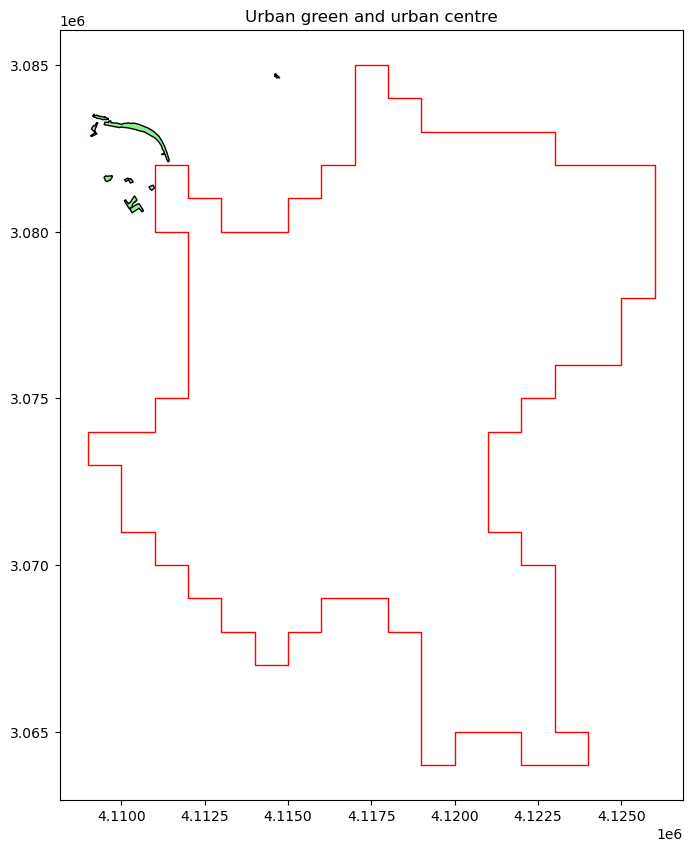

In [46]:
import geopandas as gpd
import matplotlib.pyplot as plt



# Plotting the two GeoDataFrames
fig, ax = plt.subplots(figsize=(10, 10))
uagreen.plot(ax=ax, color='lightgreen', edgecolor='black')
uc_city.plot(ax=ax, edgecolor='red', color='none')

# Customize the plot (optional)
ax.set_title('Urban green and urban centre')
plt.show()


In [49]:
if not nqgreen.empty:
    print('not empty')

In [50]:
if nqgreen.empty:
    print('empty')

empty


In [29]:
counter= 1
agl_error_ls = []


# Loop through test cities
for uc_city_code in cities_ls[27:28]:
    print(counter)
    start_time = datetime.now()
    print(str(start_time))
    #urban centre boundary delineation
    uc_city = uc_sel.query(f"HDENS_CLST=='{uc_city_code}'")
    print(uc_city.HDENS_NAME)

1
2024-07-25 16:34:53.145976
167    Bonn
Name: HDENS_NAME, dtype: object


# processing SE

In [7]:


# Select cities for processing in this batch
uc_sel = uc.query('Batch==1.0 & CNTR_CODE == "SE"')
uc_sel = uc_sel.sort_values(by='CNTR_CODE')

# Read table to list the cities to process using urban centre code
cities_ls = uc_sel.HDENS_CLST.tolist()



In [8]:
cities_ls

['GEOSTAT21_018',
 'GEOSTAT21_024',
 'GEOSTAT21_025',
 'GEOSTAT21_029',
 'GEOSTAT21_048',
 'GEOSTAT21_049',
 'GEOSTAT21_054',
 'GEOSTAT21_013']

In [9]:
outdata_f = os.path.join(indata_f, 'OutputData', 'batch1_allprocessed', 'step1')

In [1]:
counter= 1
agl_error_ls = []


# Loop through test cities
for uc_city_code in cities_ls:
    print(counter)
    start_time = datetime.now()
    print(str(start_time))
    #urban centre boundary delineation
    uc_city = uc_sel.query(f"HDENS_CLST=='{uc_city_code}'")

    HDENS_AGGL_city = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}'")
    agl_id_city_ls = HDENS_AGGL_city.agglomerationId_identifier.values.astype(str).tolist()
    for agl_id in agl_id_city_ls:
        HDENS_AGGL_city_aglid = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}' & agglomerationId_identifier=='{agl_id}'")
        ctry_code = HDENS_AGGL_city_aglid.CNTR_CODE.values.astype(str)[0]
        aglo_name = HDENS_AGGL_city_aglid.agglomerationName_nameEng.values.astype(str)[0]
        city_agl_cd = f"{ctry_code}-{uc_city_code}-{agl_id}-{aglo_name}"
        print(city_agl_cd)
        if len(ctry_code.split('-'))>1:
               print('>1 countries')
               agl_error_ls.append(city_agl_cd + " bordering countries")
        else:
            print('1 country for this urban centre')      
            # Load agglomeration boundary for selected city
            agl_city = agls.query(f'agglomerationId_identifier == "{agl_id}"')
            if agl_city.empty:
                agglomerationId_identifier = 'NotAvailable'
                print ("agglomerationId_identifier Not Available")
                agl_error_ls.append(city_agl_cd + " agglomerationId_identifier Not Available")
            else:
                output_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
                if not os.path.exists(output_path):
                    try:
                        # Check noise contour maps GeoPackage file
                        ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export.gpkg')
                        layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'           
                        #ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export_{ctry_code}.gpkg')
                        #layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'
                        #layerName = f'dbodf48_agg_noisecontours_roadsinagglomeration_lden_valid_latestdelivery_poly_{ctry_code}'
                        ncm = gpd.read_file(ncm_file_path, layer=layerName, columns=['category', 'geometry'], 
                                            engine='pyogrio', use_arrow=True, bbox= tuple(agl_city.total_bounds))
                        print ("ncm")

                        # Define the list of noisy classes
                        noisy_classes = ['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']

                        # Create a condition based on the category column
                        condition = ncm['category'].isin(noisy_classes)  # Replace 'category_column' with the actual column name

                        # Specify the condition and create a new category column based on the condition
                        ncm['noisy'] = 0
                        ncm.loc[condition, 'noisy'] = 1
                        ncm = ncm[['noisy', 'geometry']]
                        ncm_dis_dg = dg.from_geopandas(ncm, npartitions=10)
                        ncm_dis = ncm_dis_dg.dissolve(by='noisy').compute().reset_index()
                        print ("ncm_dis")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_dis.shp')                       
                        ncm_dis.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_dis")
                    

                        # Perform spatial overlay (intersection) 
                        ncm_agl = gpd.overlay(ncm_dis, agl_city, how='intersection')
                        print ("ncm_agl")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_agl.shp')
                        ncm_agl.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_agl")

                        # Aggregate the area with lower band values (quieter bands)
                        ncm_agl_city = gpd.overlay(ncm_agl, agl_city, how='union')
                        print ("union")

                        ncm_agl_city['noisy'] = ncm_agl_city.noisy.fillna(0)
                        print ("fillna")

                        # Export to shapefile
                        file_path = os.path.join(temp_f, f'{city_agl_cd}_ncm_agl_city.shp')                       
                        ncm_agl_city.to_file(file_path, driver='ESRI Shapefile')
                        print ("exported ncm_agl")

                        # Select a subset of columns of interest
                        ncm_dis = ncm_agl_city[['noisy', 'geometry']]
                        print(ncm_dis)
                        

                        # 3 READ UA DATA        
                        # Load GeoPackage info
                        data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'
                        city_codes = codes.query(f'HDENS_CLST == "{uc_city_code}"')
                        ua_city_string = city_codes.UA2018.values.astype(str)[0]
                        print(ua_city_string)
                        folder_path = glob.glob(os.path.join(data_f, f'*{ua_city_string}*'))
                        ua_file_path =  glob.glob(os.path.join(folder_path[0], 'Data', f'*{ua_city_string}*.gpkg'))
                        layers_ls = fiona.listlayers(ua_file_path[0])
                        if not layers_ls:
                            agl_error_ls.append(city_agl_cd +" ua not found")
                        else:    
                            print (f"layers: {ua_file_path[0]}")

                            # Read the GeoPackage file
                            ua = gpd.read_file(ua_file_path[0], layer= layers_ls[0], 
                                            columns= ['country', 'fua_name', 'fua_code','code_2018', 'class_2018', 'geometry'], engine='pyogrio', 
                                            use_arrow=True, bbox= tuple(uc_city.total_bounds))
                            print ("loaded ua in urban city")

                            # Select 'green' classes
                            uagreen = ua.query('code_2018 == "14100" or code_2018 == "31000"')
                            
                            # 4 SELECT UA INTERSECTING UC
                            # Perform spatial overlay (intersection)
                            uagreen_urbc = gpd.overlay(uagreen, uc_city, how='intersection')
                            file_path = os.path.join(temp_f, f'{city_agl_cd}_uagreen_urbc.shp')
                            uagreen_urbc.to_file(file_path, driver='ESRI Shapefile')

                            # 5 IDENTIFY GREEN AREAS EXCLUDED (NOT COVERED BY NCM)
                            # Perform spatial overlay (intersection)                          
                            nqgreen = gpd.overlay(uagreen_urbc, ncm_dis, how='intersection') #noisy/quiet green
                            file_path = os.path.join(temp_f, f'{city_agl_cd}_nqgreen.shp')
                            nqgreen.to_file(file_path, driver='ESRI Shapefile')
                            
                            not_covered = uagreen_urbc.geometry.difference(uagreen_urbc.geometry.intersection(nqgreen.geometry.unary_union))
                            file_path = os.path.join(temp_f, f'{city_agl_cd}_not_covered.shp')
                            not_covered.to_file(file_path, driver='ESRI Shapefile')

                            # Filter out empty polygons(not empty polygons)
                            green_not_covered_by_ncm = not_covered[~not_covered.is_empty]

                            # save to shapefile
                            file_path = os.path.join(outdata_f, f'{city_agl_cd}_green_not_covered_by_ncm.shp')
                            green_not_covered_by_ncm.to_file(file_path, driver='ESRI Shapefile')
                            print ("green_not_covered_by_ncm")

                            # 6 IDENTIFY QUIET/NOISY AREAS
                            ## for statistics need to calculate area again
                            # Calculate the area for each geometry and create a new column 'area'
                            nqgreen['area_m2'] = nqgreen['geometry'].area
                            nqgreen['area_ha'] = round(nqgreen['area_m2']* 0.0001,2)
                            nqgreen['area_km2'] = round(nqgreen['area_ha']* 0.01,2)
                            nqgreen_area = nqgreen.groupby(['code_2018', 'noisy'])['area_m2'].sum().reset_index()
                            nqgreen_area['area_ha'] = round(nqgreen_area['area_m2']* 0.0001,2)
                            nqgreen_area['area_km2'] = round(nqgreen_area['area_ha']* 0.01,2)

                            # 7 EXPORT GREEN QUIET AREAS (GQA)
                            nqgreen = nqgreen[['country', 'fua_name', 'fua_code', 'HDENS_2011', 'code_2018', 'class_2018', 'noisy',  'area_m2', 'area_ha', 'area_km2', 'geometry']]
                            GQA = nqgreen.query('noisy == 0')
                            GNA = nqgreen.query('noisy == 1')

                            # Export to shapefile
                            file_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA.shp')
                            GQA.to_file(file_path, driver='ESRI Shapefile')
                            print ("GQA")

                            # 8 CREATE CENTROIDS FOR GQA POLYGONS
                            # Create a new GeoDataFrame with centroids as points
                            GQA_pts = gpd.GeoDataFrame(geometry=GQA['geometry'].centroid)
                            GQA_pts['oid'] = GQA.index
                            GQA_pts['fua_name'] = GQA.fua_name
                            GQA_pts['fua_code'] = GQA.fua_code
                            GQA_pts['HDENS_2011'] = GQA.HDENS_2011

                            # Export to shapefile
                            file_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
                            GQA_pts.to_file(file_path, driver='ESRI Shapefile')
                            print ("GQA_pts")
                    
                            # Calculate the duration
                            end_time = datetime.now()
                            processing_time = end_time - start_time

                            print ("str(processing_time)")
                            
                            ## write output values into log file
                            uc_km2 = round(uc_city.area.sum()/1000000,2)
                            agl_city_km2 = round(agl_city.area.sum()/1000000,2)
                            ncm_agl_city_km2 = round(ncm_agl_city.area.sum()/1000000,2)
                            ua_km2 = round(ua.area.sum()/1000000,2)
                            uagreen_km2 = round(uagreen.area.sum()/1000000,2)
                            uagreen_urbc_km2 = round(uagreen_urbc.area.sum()/1000000,2)
                            nqgreen_m2 = round(nqgreen.area.sum(),2)
                            green_not_covered_by_ncm_m2 = round(green_not_covered_by_ncm.area.sum(),2)
                            GQA_m2 = round(GQA.area.sum(),2)
                            GNA_m2 = round(GNA.area.sum(),2)
                            processing_duration = str(processing_time)

                            log_entry = create_log_entry(aglo_name, agl_id, uc_km2, agl_city_km2, 
                                                    ncm_agl_city_km2,ua_km2, uagreen_km2, uagreen_urbc_km2, nqgreen_m2, 
                                                    green_not_covered_by_ncm_m2, GQA_m2, GNA_m2, processing_time)
                            write_log(log_path, log_entry)

                            # Clean up intermediate variables to free memory
                            del agl_city, ncm, ncm_agl, ncm_agl_city, ncm_dis, ua, uagreen, uagreen_urbc, nqgreen, green_not_covered_by_ncm, GQA, GNA, GQA_pts
                    except:
                        print("Error " + city_agl_cd)
                        agl_error_ls.append(city_agl_cd +" Topological error")
        counter= counter+1

print(agl_error_ls)

NameError: name 'cities_ls' is not defined